In [1]:
import numpy as np
import torch
from pyro import distributions as dist
from pyro.poutine import trace, uncondition
from torch.distributions import constraints
import pyro.optim
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.infer import NUTS,MCMC
import matplotlib.pyplot as plt
import pdb
import sys
sys.path.append("../..")
from models_and_guides import *
from initializations import *

In [2]:
from pyro.infer.autoguide import AutoDiagonalNormal

In [3]:
def piecewise_eval(knot_x, knot_y, x):
    # I haven't unit tested this:
    n_knots = knot_x.size(-1)
    assert n_knots >= 2
    knot_x, idx = knot_x.sort(dim=-1)
    knot_y = knot_y.gather(-1,idx)
    lb = (x.unsqueeze(-1) > knot_x[...,1:].unsqueeze(-2)).long().sum(-1)
    lb[lb >= n_knots - 1] = n_knots - 2
    ub = lb + 1
    x0 = knot_x.gather(-1,lb)
    x1 = knot_x.gather(-1,ub)
    y0 = knot_y.gather(-1,lb)
    y1 = knot_y.gather(-1,ub)
    slopes = (y1-y0)/(x1-x0).clamp(min=1e-8)
    return slopes*x + (y1 - slopes*x1)
    
def piecewise_regression(x, y, n_pieces=3):
    knot_x = pyro.sample("knot_x",
                         dist.Uniform(0, 100)
                             .expand([n_pieces]).to_event(0))
    knot_y = pyro.sample("knot_y",
                         dist.Normal(0, 100)
                             .expand([n_pieces]).to_event(0))
    y_pred = piecewise_eval(knot_x, knot_y, x)
    y_scale = pyro.sample("y_scale", dist.LogNormal(0, 1))
    y = pyro.sample("obs", dist.Normal(y_pred, y_scale),
                obs=y)
    return y

In [4]:
N = 100
x = torch.arange(N)
n_pieces = 3
dgp_trace = trace(uncondition(piecewise_regression)).get_trace(x,x,n_pieces)

In [5]:
dgp_vars = {name:dgp_trace.nodes[name]['value'] for name in dgp_trace.reparameterized_nodes}

In [6]:
y = dgp_vars['obs']

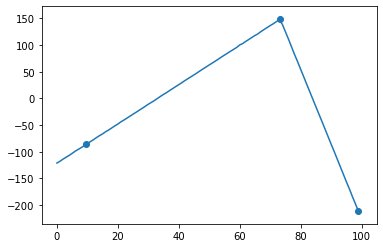

In [7]:
plt.plot(x,y)
plt.scatter(dgp_vars['knot_x'],dgp_vars['knot_y'])

In [8]:
guide = AutoDiagonalNormal(piecewise_regression,init_scale=1.5)

In [9]:
pyro.clear_param_store()

In [10]:
optim = pyro.optim.Adam({"lr": 0.003})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, guide, optim, loss=elbo)

In [11]:
losses = []
guide(x,y,n_pieces)
param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})

for i in range(500):
    losses.append(svi.step(x,y,n_pieces))
    param_history = {k:torch.cat([param_history[k],v.unsqueeze(0).detach()],dim=0) for k,v in pyro.get_param_store().items()}

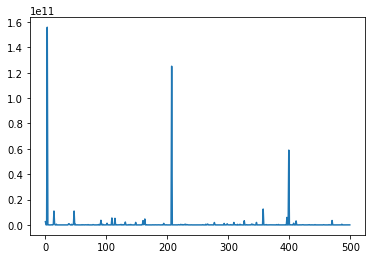

In [12]:
plt.plot(losses)

In [13]:
param_history

{'AutoDiagonalNormal.loc': tensor([[-0.3240,  0.1526, -0.3578,  ...,  9.0931, 10.5708, -0.1594],
         [-0.3240,  0.1526, -0.3578,  ...,  9.0931, 10.5708, -0.1594],
         [-0.3236,  0.1503, -0.3563,  ...,  9.0921, 10.5728, -0.1573],
         ...,
         [-0.3366,  0.2103, -0.3310,  ...,  9.4135, 10.6258, -0.0670],
         [-0.3366,  0.2103, -0.3310,  ...,  9.4135, 10.6258, -0.0670],
         [-0.3366,  0.2103, -0.3310,  ...,  9.4135, 10.6258, -0.0670]],
        grad_fn=<CatBackward>),
 'AutoDiagonalNormal.scale': tensor([[1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
         [1.5045, 1.4955, 1.5045,  ..., 1.5045, 1.5045, 1.4955],
         [1.5087, 1.4985, 1.5024,  ..., 1.5087, 1.5075, 1.4924],
         ...,
         [1.4277, 1.5833, 1.5891,  ..., 1.4669, 1.4863, 1.3700],
         [1.4277, 1.5833, 1.5891,  ..., 1.4668, 1.4863, 1.3699],
         [1.4277, 1.5833, 1.5891,  ..., 1.4668, 1.4863, 1.3699]],
        grad_fn=<CatBackward>)}

In [14]:
param_history['AutoDiagonalNormal.loc'][-1]

tensor([-0.3366,  0.2103, -0.3310, 46.9457,  9.4135, 10.6258, -0.0670],
       grad_fn=<SelectBackward>)

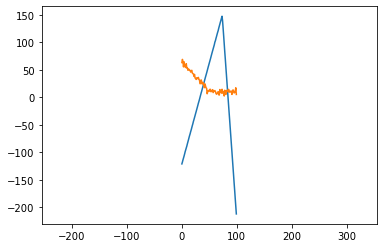

In [15]:
#pred = pyro.infer.predictive.Predictive(uncondition(piecewise_regression),guide=guide,num_samples=10)
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=guide,num_samples=1)

fit = pred(x,y,n_pieces)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

%matplotlib inline
plt.plot(x,y)
plt.errorbar(x,fit_obs_mean,yerr=fit_obs_std)
plt.axis('equal');
#plt.plot(x,slope_fit*x.numpy()+intercept_fit)
#plt.plot(x,fit_obs)

In [16]:
dgp_vars

{'knot_x': tensor([73.3172, 98.9247,  9.6973]),
 'knot_y': tensor([ 148.4864, -211.1701,  -85.8324]),
 'y_scale': tensor(0.2213),
 'obs': tensor([-1.2125e+02, -1.1787e+02, -1.1390e+02, -1.1050e+02, -1.0696e+02,
         -1.0313e+02, -9.9032e+01, -9.5648e+01, -9.2220e+01, -8.8864e+01,
         -8.4807e+01, -8.1120e+01, -7.7412e+01, -7.3516e+01, -6.9813e+01,
         -6.6552e+01, -6.2554e+01, -5.9283e+01, -5.5457e+01, -5.1644e+01,
         -4.8139e+01, -4.4023e+01, -4.0600e+01, -3.6979e+01, -3.3369e+01,
         -2.9589e+01, -2.6023e+01, -2.2296e+01, -1.8625e+01, -1.4833e+01,
         -1.0969e+01, -7.5945e+00, -4.0290e+00, -1.4915e-01,  3.7197e+00,
          7.4605e+00,  1.0841e+01,  1.4713e+01,  1.8344e+01,  2.2176e+01,
          2.5653e+01,  2.9448e+01,  3.3286e+01,  3.6942e+01,  4.0462e+01,
          4.4064e+01,  4.7741e+01,  5.1627e+01,  5.5385e+01,  5.8982e+01,
          6.2655e+01,  6.6243e+01,  6.9825e+01,  7.3641e+01,  7.7452e+01,
          8.1153e+01,  8.4761e+01,  8.8370e+01,  

In [17]:
fit

{'knot_x': tensor([[16.2464, 83.3793, 47.5878]], grad_fn=<ViewBackward>),
 'knot_y': tensor([[46.2696,  8.9400, 11.2064]], grad_fn=<ViewBackward>),
 'y_scale': tensor([3.1582], grad_fn=<ViewBackward>),
 'obs': tensor([[62.9722, 68.7279, 64.9270, 55.0582, 64.2958, 57.2852, 54.9322, 53.9823,
          60.9602, 53.0500, 53.6055, 48.9217, 51.0313, 50.6266, 48.8422, 48.6973,
          45.6386, 47.6643, 48.8852, 43.8513, 42.9309, 42.2853, 37.8693, 41.4420,
          34.7745, 34.1224, 32.2807, 35.2123, 35.3559, 33.5556, 36.0015, 32.5792,
          30.9475, 24.5378, 24.8698, 31.5000, 28.4748, 23.9139, 26.7626, 25.7623,
          21.3197, 17.3711, 24.1588, 20.4523, 16.9440, 16.1669,  6.2515,  9.9034,
          12.2867, 11.9441, 10.7931, 14.3687, 14.2299,  9.8708, 11.8717, 10.6575,
          13.6988,  8.4111, 11.1849, 11.2003, 12.0580, 10.3179,  6.7833,  5.4046,
           6.4839,  8.6188,  9.9942,  4.4687,  3.8553, 13.9637,  8.7190, 11.2797,
           7.4181, 14.4400,  7.4696, 10.7740,  8.8409